# Regression

## Objectives

*   Fit and evaluate a regression model to predict tenure levels for a prospect that will likely churn


## Inputs

* outputs/datasets/collection/HousePriceRecords.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict Sale Price
* labels map
* Feature Importance Plot

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/p5test/jupyter_notebooks'

We want to make the parent of the current directory the new current directory.
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/p5test'

---

# Load Data

In [4]:
import numpy as np
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/HousePriceRecords.csv")
      #.query("Churn == 1")  # subset churned customer
      .drop(labels=['2ndFlrSF', 'BedroomAbvGr', 'EnclosedPorch', 'GarageYrBlt', 'LotFrontage', 'MasVnrArea', 'WoodDeckSF', 'BsmtExposure', 'BsmtFinType1', 'GarageFinish'], axis=1)
      # variables we will not need for this project
      # we will not need Churn since it has only 1
      )

print(df.shape)
df.head(3)

(1460, 14)


1stFlrSF  BsmtFinSF1  BsmtUnfSF  GarageArea  GrLivArea KitchenQual  \
0       856         706        150         548       1710          Gd   
1      1262         978        284         460       1262          TA   
2       920         486        434         608       1786          Gd   

   LotArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0     8450           61            5            7          856       2003   
1     9600            0            8            6         1262       1976   
2    11250           42            5            7          920       2001   

   YearRemodAdd  SalePrice  
0          2003     208500  
1          1976     181500  
2          2002     223500

# MP Pipeline: Regressor

## Create ML pipeline

In [5]:
from sklearn.pipeline import Pipeline

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['KitchenQual'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base


Custom Class for hyperparameter optimisation

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split Train Test Set

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)


* Train set: (1168, 13) (1168,) 
* Test set: (292, 13) (292,)


## Grid Search CV - Sklearn

### Use default hyperparameters to find most suitable algorithm

In [8]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

Do a hyperparameter optimisation search using default hyperparameters

In [9]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_d


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_d


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_d


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_d


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_d


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDty

Check results

In [10]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

estimator min_score mean_score max_score std_score
2      RandomForestRegressor  0.679313   0.802884   0.85964  0.066075
3        ExtraTreesRegressor  0.617934   0.794258  0.857411   0.09136
5  GradientBoostingRegressor   0.61548   0.757334  0.850056  0.094957
6               XGBRegressor  0.606111   0.752809  0.828932  0.088447
0           LinearRegression  0.641493   0.750842  0.800675  0.057664
4          AdaBoostRegressor  0.535817   0.611221  0.708537  0.055653
1      DecisionTreeRegressor  0.176749   0.495349  0.662821  0.180813

### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters, for Extensive Search

In [11]:
models_search = {
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may consider more hyperparameters and spend more time in this step

params_search = {
    "GradientBoostingRegressor": {
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10,None],
    }
}

Extensive GridSearch CV

In [12]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_d

Check results

In [13]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

estimator min_score mean_score max_score std_score  \
7   GradientBoostingRegressor  0.660255   0.763022  0.850032  0.081415   
0   GradientBoostingRegressor   0.61548   0.757334  0.850056  0.094957   
9   GradientBoostingRegressor    0.6799   0.750736  0.837156  0.052398   
1   GradientBoostingRegressor  0.592652   0.745357  0.825227   0.09726   
2   GradientBoostingRegressor  0.628312   0.740112  0.823137  0.065139   
3   GradientBoostingRegressor  0.627882    0.73969  0.822807  0.065211   
11  GradientBoostingRegressor  0.563449   0.685805  0.796302  0.077472   
8   GradientBoostingRegressor   0.64234   0.676022  0.748431  0.037962   
4   GradientBoostingRegressor  0.511632   0.667566  0.781933  0.091685   
5   GradientBoostingRegressor  0.511609   0.667557  0.781926  0.091692   
10  GradientBoostingRegressor  0.614453   0.659874  0.739549  0.042459   
6   GradientBoostingRegressor  0.557331   0.616296  0.674171   0.05121   
17  GradientBoostingRegressor  0.321833   0.364335  0.406774   0.03435   
15  GradientBoostingRegressor  0.332481   0.363231  0.398678  0.028778   
13  GradientBoostingRegressor  0.262818   0.287036  0.319623  0.020747   
16  GradientBoostingRegressor  0.122208   0.144328   0.17075  0.019961   
14  GradientBoostingRegressor  0.120689    0.14353  0.169148  0.018939   
12  GradientBoostingRegressor  0.096199   0.105837  0.122189   0.00901   

   model__learning_rate model__max_depth model__n_estimators  
7                  0.01                3                 300  
0                   0.1                3                 100  
9                  0.01               10                 300  
1                   0.1                3                 300  
2                   0.1               10                 100  
3                   0.1               10                 300  
11                 0.01             None                 300  
8                  0.01               10                 100  
4                   0.1             None                 100  
5                   0.1             None                 300  
10                 0.01             None                 100  
6                  0.01                3                 100  
17                0.001             None                 300  
15                0.001               10                 300  
13                0.001                3                 300  
16                0.001             None                 100  
14                0.001               10                 100  
12                0.001                3                 100

Check the best model

In [14]:
best_model = grid_search_summary.iloc[0, 0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [15]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.01,
 'model__max_depth': 3,
 'model__n_estimators': 300}

Define the best regressor, based on search

In [16]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingRegressor(random_state=0))),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.01, n_estimators=300,
                                           random_state=0))])

## Assess feature importance

/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):


* These are the 4 most important features in descending order. The model was trained on them: 
['GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'GarageArea']


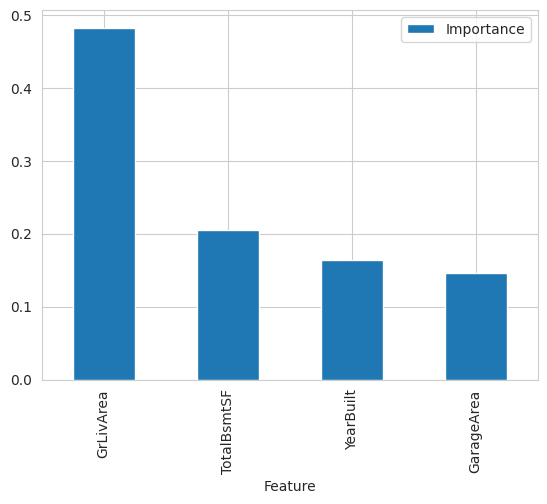

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(best_regressor_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_regressor_pipeline['feat_selection'].get_support()],
    'Importance': best_regressor_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate on Train and Test Sets

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Evaluate Performance

Model Evaluation 

* Train Set
R2 Score: 0.867
Mean Absolute Error: 19962.828
Mean Squared Error: 821104786.449
Root Mean Squared Error: 28654.926


* Test Set
R2 Score: 0.803
Mean Absolute Error: 23241.823
Mean Squared Error: 1363082934.903
Root Mean Squared Error: 36919.953




/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_d

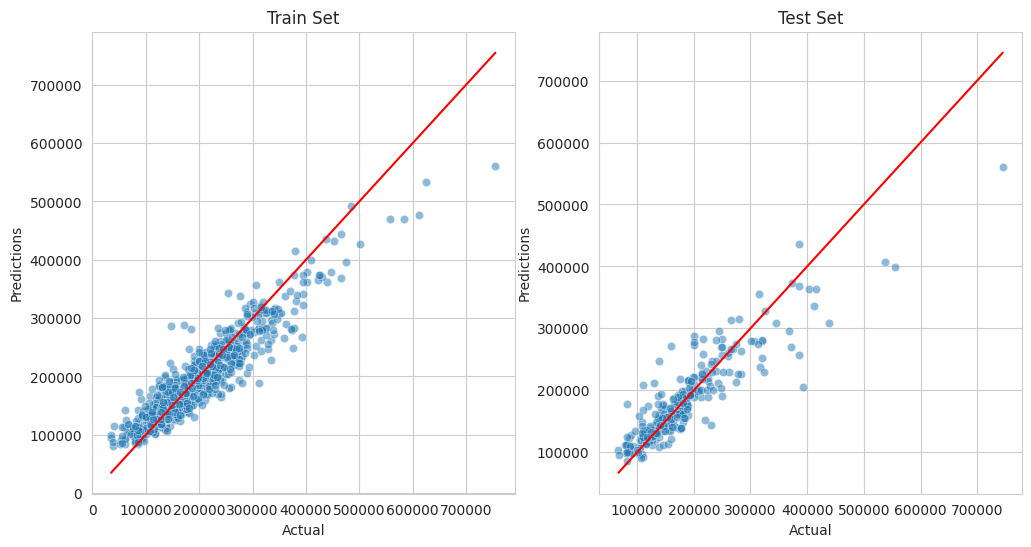

In [19]:
regression_performance(X_train, y_train, X_test, y_test, best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_regressor_pipeline)

# Regressor with PCA

Let's explore potential values for PCA n_components.

In [25]:
# pipeline = PipelineOptimization(model=LinearRegression())
# pipeline_pca = Pipeline(pipeline.steps[:3])
# df_pca = pipeline_pca.fit_transform(df.drop(['SalePrice'], axis=1))

# print(df_pca.shape,'\n', type(df_pca))

Apply PCA separately to the scaled data

In [26]:
# import numpy as np
# from sklearn.decomposition import PCA

# n_components = 17


# def pca_components_analysis(df_pca, n_components):
#     pca = PCA(n_components=n_components).fit(df_pca)
#     x_PCA = pca.transform(df_pca)  # array with transformed PCA

#     ComponentsList = ["Component " + str(number)
#                       for number in range(n_components)]
#     dfExplVarRatio = pd.DataFrame(
#         data=np.round(100 * pca.explained_variance_ratio_, 3),
#         index=ComponentsList,
#         columns=['Explained Variance Ratio (%)'])

#     dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
#     )

#     PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
#     )

#     print(
#         f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
#     plt.figure(figsize=(12, 5))
#     sns.lineplot(data=dfExplVarRatio,  marker="o")
#     plt.xticks(rotation=90)
#     plt.yticks(np.arange(0, 110, 10))
#     plt.show()


# pca_components_analysis(df_pca=df_pca, n_components=n_components)

In [27]:
# n_components = 7
# pca_components_analysis(df_pca=df_pca, n_components=n_components)

## Rewrite ML Pipeline for Modelling

In [28]:
# PCA
from sklearn.decomposition import PCA


def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['KitchenQual'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),


        ("feat_scaling", StandardScaler()),

        # PCA replace Feature Selection
        ("PCA", PCA(n_components=7, random_state=0)),

        ("model", model),

    ])

    return pipeline_base

## Grid Search CV – Sklearn

In [29]:
print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 13) (1168,) 
* Test set: (292, 13) (292,)


### Use standard hyperparameters to find the most suitable model.

In [30]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}


Do a quick optimisation search 

In [32]:
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_d


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_d


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_d


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_d


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_d


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/usr/local/python/3.12.1/lib/python3.12/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDty

Check results

In [45]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

estimator min_score mean_score max_score std_score
3        ExtraTreesRegressor   0.72225   0.810708  0.845007  0.047712
5  GradientBoostingRegressor  0.718832   0.804893  0.844427  0.046561
2      RandomForestRegressor   0.72533   0.802886  0.834463  0.041083
6               XGBRegressor  0.694154   0.788076  0.847745  0.052285
0           LinearRegression  0.639345   0.757416  0.824015   0.06387
4          AdaBoostRegressor  0.653808    0.74727  0.784055  0.049228
1      DecisionTreeRegressor  0.479776   0.623897  0.754421  0.104399

### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define model and parameters for extensive search

In [34]:
models_search = {
    "GradientBoostingRegressor":GradientBoostingRegressor(random_state=0),
}

# documentation to help on hyperparameter list: 
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

# We will not conduct an extensive search, since the focus
# is on how to combine all knowledge in an applied project.
# In a workplace project, you may spend more time in this step
params_search = {
    "GradientBoostingRegressor":{
        'model__n_estimators': [100,300],
        'model__learning_rate': [1e-1,1e-2,1e-3], 
        'model__max_depth': [3,10, None],
    }
}

Extensive GridSearch CV

In [35]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train, scoring = 'r2', n_jobs=-1, cv=5)


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_d

Check results

In [36]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

estimator min_score mean_score max_score std_score  \
0   GradientBoostingRegressor  0.718832   0.804893  0.844427  0.046561   
1   GradientBoostingRegressor  0.721421   0.797506  0.838549  0.042398   
7   GradientBoostingRegressor  0.716141   0.788622  0.829662  0.039488   
2   GradientBoostingRegressor  0.651442   0.746319  0.807924  0.059389   
3   GradientBoostingRegressor  0.651493   0.746312  0.807976  0.059399   
9   GradientBoostingRegressor  0.641087   0.741072  0.803537  0.063112   
11  GradientBoostingRegressor  0.593325   0.677399  0.760786  0.066662   
8   GradientBoostingRegressor   0.61366   0.673086  0.723599  0.039901   
4   GradientBoostingRegressor  0.580115   0.667629  0.767035  0.072129   
5   GradientBoostingRegressor    0.5801    0.66762  0.767032  0.072132   
10  GradientBoostingRegressor  0.609726   0.653096  0.713437  0.039328   
6   GradientBoostingRegressor  0.591361   0.646793  0.683624  0.038624   
15  GradientBoostingRegressor  0.342003   0.361005  0.396335  0.019218   
17  GradientBoostingRegressor  0.344814   0.360379  0.395968  0.018989   
13  GradientBoostingRegressor  0.301731   0.320988  0.334586  0.013757   
16  GradientBoostingRegressor   0.12393   0.142557  0.157695  0.010898   
14  GradientBoostingRegressor  0.123037    0.14154   0.15661  0.010874   
12  GradientBoostingRegressor  0.111128   0.120239  0.130534  0.006305   

   model__learning_rate model__max_depth model__n_estimators  
0                   0.1                3                 100  
1                   0.1                3                 300  
7                  0.01                3                 300  
2                   0.1               10                 100  
3                   0.1               10                 300  
9                  0.01               10                 300  
11                 0.01             None                 300  
8                  0.01               10                 100  
4                   0.1             None                 100  
5                   0.1             None                 300  
10                 0.01             None                 100  
6                  0.01                3                 100  
15                0.001               10                 300  
17                0.001             None                 300  
13                0.001                3                 300  
16                0.001             None                 100  
14                0.001               10                 100  
12                0.001                3                 100

Check the best model

In [37]:
best_model = grid_search_summary.iloc[0,0]
best_model

'GradientBoostingRegressor'

Parameters for best model

In [38]:
grid_search_pipelines[best_model].best_params_

{'model__learning_rate': 0.1,
 'model__max_depth': 3,
 'model__n_estimators': 100}

Define the best regressor

In [39]:
best_regressor_pipeline = grid_search_pipelines[best_model].best_estimator_
best_regressor_pipeline

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['KitchenQual'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('PCA', PCA(n_components=7, random_state=0)),
                ('model', GradientBoostingRegressor(random_state=0))])

## Evaluate Regressor on Train and Tests Sets

Model Evaluation 

* Train Set
R2 Score: 0.928
Mean Absolute Error: 15421.468
Mean Squared Error: 444505646.182
Root Mean Squared Error: 21083.303


* Test Set
R2 Score: 0.825
Mean Absolute Error: 22225.492
Mean Squared Error: 1211841612.273
Root Mean Squared Error: 34811.516




/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(X[feature]):
/usr/local/python/3.12.1/lib/python3.12/site-packages/feature_engine/encoding/base_encoder.py:223: FutureWarning: is_categorical_d

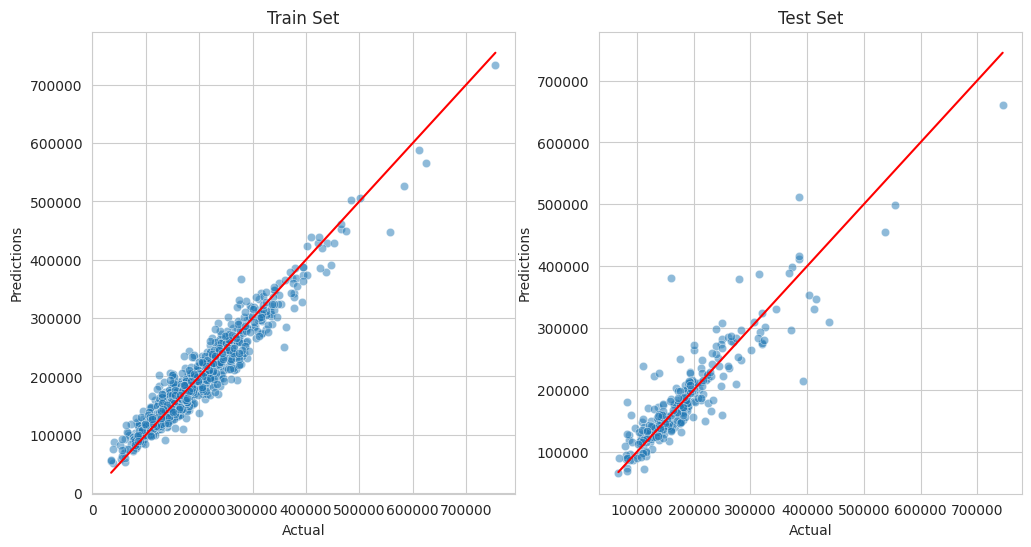

In [40]:
regression_performance(X_train, y_train, X_test, y_test,best_regressor_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test,
                            best_regressor_pipeline)

# Convert Regression to Classification

### Convert numerical target to bins, and check if it is balanced

* The classes represent the following ranges: 
{'SalePrice': [-inf, 34900.856641428574, 34901.71328285714, 34902.569924285715, 34903.42656571428, 34904.28320714286, 34905.13984857143, 34905.99649, 34906.85313142857, 34907.709772857146, 34908.56641428571, 34909.42305571429, 34910.279697142854, 34911.13633857143, 34911.99298, 34912.84962142857, 34913.706262857144, 34914.56290428571, 34915.419545714285, 34916.27618714286, 34917.132828571426, 34917.98947, 34918.846111428575, 34919.70275285714, 34920.559394285716, 34921.41603571428, 34922.27267714286, 34923.12931857143, 34923.98596, 34924.84260142857, 34925.69924285714, 34926.55588428571, 34927.41252571429, 34928.269167142855, 34929.12580857143, 34929.98245, 34930.83909142857, 34931.695732857144, 34932.55237428571, 34933.409015714285, 34934.26565714286, 34935.12229857143, 34935.97894, 34936.83558142857, 34937.69222285714, 34938.548864285716, 34939.40550571428, 34940.26214714286, 34941.11878857143, 34941.97543, 34942.83207142857, 34943.68871

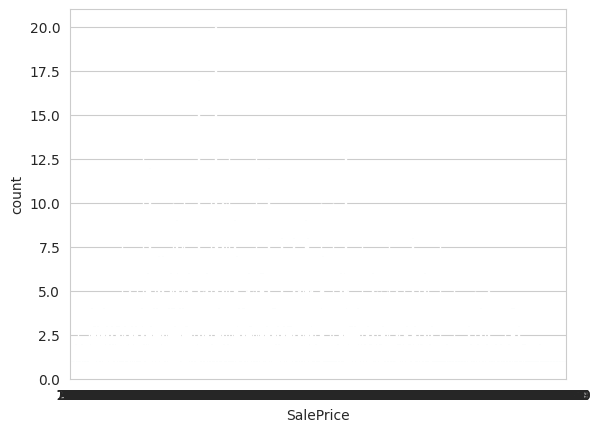

In [44]:
from feature_engine.discretisation import EqualFrequencyDiscretiser
disc = EqualFrequencyDiscretiser(q=700000, variables=['SalePrice'])  # we will try q as 2, and 3
df_clf = disc.fit_transform(df)

print(f"* The classes represent the following ranges: \n{disc.binner_dict_} \n")
sns.countplot(data=df_clf, x='SalePrice')
plt.show()

In [42]:
df_clf.head()

1stFlrSF  BsmtFinSF1  BsmtUnfSF  GarageArea  GrLivArea KitchenQual  \
0       856         706        150         548       1710          Gd   
1      1262         978        284         460       1262          TA   
2       920         486        434         608       1786          Gd   
3       961         216        540         642       1717          Gd   
4      1145         655        490         836       2198          Gd   

   LotArea  OpenPorchSF  OverallCond  OverallQual  TotalBsmtSF  YearBuilt  \
0     8450           61            5            7          856       2003   
1     9600            0            8            6         1262       1976   
2    11250           42            5            7          920       2001   
3     9550           35            5            7          756       1915   
4    14260           84            5            8         1145       2000   

   YearRemodAdd  SalePrice  
0          2003          2  
1          1976          1  
2          2002          2  
3          1970          1  
4          2000          2

## Rewrite ML Pipeline for Modelling

In [24]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['KitchenQual'])),


        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

## Load algorithms for classification

In [25]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

## Split Train Test Sets

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['SalePrice'], axis=1),
    df_clf['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

NameError: name 'train_test_split' is not defined

## Grid Seach CV – Sklearn

### Use standard hyper parameters to find most suitable model

In [27]:
models_quick_search = {
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "XGBClassifier":{},
    "DecisionTreeClassifier":{},
    "RandomForestClassifier":{},
    "GradientBoostingClassifier":{},
    "ExtraTreesClassifier":{},
    "AdaBoostClassifier":{},
}

GridSearch CV

In [28]:
from sklearn.metrics import make_scorer, recall_score
quick_search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
quick_search.fit(X_train, y_train,
                 scoring = make_scorer(recall_score, labels=[0], average=None),
                 n_jobs=-1,
                 cv=5)

NameError: name 'HyperparameterOptimizationSearch' is not defined

Check results

In [29]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary

NameError: name 'quick_search' is not defined

### Do an extensive search on the most suitable model to find the best hyperparameter configuration.

Define models and parameters

In [30]:
models_search = {
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

# documentation to help on hyperparameter list:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
params_search = {
    "AdaBoostClassifier": {
        'model__n_estimators': [50, 100, 300],
        'model__learning_rate': [1e-1, 1e-2, 1e-3],
    }
}

Extensive GridSearch CV

In [31]:
from sklearn.metrics import make_scorer,  recall_score
search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring=make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1, cv=5)

NameError: name 'HyperparameterOptimizationSearch' is not defined

Check results

In [32]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

NameError: name 'search' is not defined

Check the best model

In [33]:
best_model = grid_search_summary.iloc[0,0]
best_model

NameError: name 'grid_search_summary' is not defined

Parameters for best model
* We are saving this content for later

In [34]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

NameError: name 'grid_search_pipelines' is not defined

Define the best clf pipeline

In [35]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

NameError: name 'grid_search_pipelines' is not defined

## Assess feature importance

We can assess feature importance for this model with `.feature_importances_`

In [37]:
# after data cleaning and feat engine, the feature may space changes
# how much data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 2
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

# best_features = columns_after_data_cleaning_feat_eng
best_features = columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[pipeline_clf['feat_selection'].get_support()],
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# reassign best features in order
best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{best_features}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

NameError: name 'Pipeline' is not defined

## Evaluate Classifier on Train and Test Sets

Custom Function

In [38]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

List that relates the classes and tenure interval

In [39]:
disc.binner_dict_['SalePrice']

AttributeError: 'EqualFrequencyDiscretiser' object has no attribute 'binner_dict_'

We can create manually

In [41]:
label_map = ['<10000.0', '10000.0 to 700000.0','+700000.0']
label_map

['<10000.0', '10000.0 to 700000.0', '+700000.0']

In [42]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

NameError: name 'X_train' is not defined

# Which pipeline to choose?

We fitted 3 pipelines:
* Regression
* Regression with PCA
* Classifier

The regressor pipelines didn't reach the expected performance threshold (0.7 R2 score) for the train and test set.

The classifier was tuned on Recall for class 0 (tenure <4 months), since we are interested to detect prospects that may churn soon. 
* It has reasonable performance for class 0 (<4 months) and class 2 (+20 months)
* Class 1 (4 to 20 months) has weak performance.

In [43]:
pipeline_clf

NameError: name 'pipeline_clf' is not defined

# Refit pipeline with best features

## Rewrite Pipeline

In [44]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['KitchenQual'])),

        ("feat_scaling", StandardScaler()),

        # feature selection is not needed

        ("model", model),

    ])

    return pipeline_base

## Split Train Test Set, only with best features

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['SalePrice'], axis=1),
    df_clf['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

NameError: name 'train_test_split' is not defined

Subset Best Features

In [46]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)
X_train.head(3)

NameError: name 'X_train' is not defined

## Grid Search CV – Sklearn

We are using the same model from the previous GridCV search

In [47]:
models_search

{'AdaBoostClassifier': AdaBoostClassifier(random_state=0)}

And the best parameters from the previous GridCV search

In [48]:
best_parameters

NameError: name 'best_parameters' is not defined

You will need to type in manually since the hyperparameter values have to be a list. The previous dictionary is not in this format.

In [49]:
params_search = {'AdaBoostClassifier':  {
    'model__learning_rate': [0.001],   # the value should be in []
    'model__n_estimators': [50]       # the value should be in []
}
}
params_search

{'AdaBoostClassifier': {'model__learning_rate': [0.001],
  'model__n_estimators': [50]}}

GridSearch CV

In [50]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring = make_scorer(recall_score, labels=[0], average=None),
           n_jobs=-1,cv=5)

NameError: name 'HyperparameterOptimizationSearch' is not defined


Check results

In [51]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

NameError: name 'search' is not defined

Check the best model

In [54]:
best_model = grid_search_summary.iloc[0,0]
best_model

NameError: name 'grid_search_summary' is not defined

Define the best clf pipeline

In [53]:
pipeline_clf = grid_search_pipelines[best_model].best_estimator_
pipeline_clf

NameError: name 'grid_search_pipelines' is not defined

## Assess feature importance

In [55]:
# how many data cleaning and feature engineering does your pipeline have?
data_cleaning_feat_eng_steps = 1
columns_after_data_cleaning_feat_eng = (Pipeline(pipeline_clf.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng,
    'Importance': pipeline_clf['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

NameError: name 'Pipeline' is not defined

## Evaluate Classifier on Train and Test Sets

In [56]:
clf_performance(X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test,
                        pipeline=pipeline_clf,
                        label_map= label_map )

NameError: name 'X_train' is not defined

# Push files to the repo

We will generate the following files

* Train set
* Test set
* Modeling pipeline
* label map
* features importance plot

In [57]:
import joblib
import os

version = 'v1'
file_path = f'outputs/ml_pipeline/sale_price_tenure/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

## Train Set: features and target

In [58]:
X_train.head()

NameError: name 'X_train' is not defined

In [59]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

NameError: name 'X_train' is not defined

In [60]:
y_train

NameError: name 'y_train' is not defined

In [61]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

NameError: name 'y_train' is not defined

## Test Set: features and target

In [62]:
X_test.head()

NameError: name 'X_test' is not defined

In [63]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

NameError: name 'X_test' is not defined

In [64]:
y_test


NameError: name 'y_test' is not defined

In [65]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

NameError: name 'y_test' is not defined

## Modelling pipeline

ML pipeline for predicting tenure

In [66]:
pipeline_clf

NameError: name 'pipeline_clf' is not defined

In [67]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/clf_pipeline.pkl")

NameError: name 'pipeline_clf' is not defined

## List  mapping target levels to ranges

Map for converting numerical variable to categorical variable

In [68]:
label_map

['<10000.0', '10000.0 to 700000.0', '+700000.0']

In [69]:
joblib.dump(value=label_map, filename=f"{file_path}/label_map.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/ml_pipeline/sale_price_tenure/v1/label_map.pkl'

## Feature importance plot

In [70]:
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

NameError: name 'df_feature_importance' is not defined

In [71]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')

NameError: name 'df_feature_importance' is not defined

End

---